In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader
from datasets import Dataset

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load Dataset

In [ ]:
data = pd.read_csv("/content/Combined Data.csv")

In [ ]:
data.dropna(inplace = True)
data

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)
data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
data = data.sample(n = 6000, random_state = 42).reset_index(drop = True)

In [ ]:
data

,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal
...,...,...
5995,What is around you right now? A photo? A comfo...,Depression
5996,I am tired. I am ready for everything to be ov...,Suicidal
5997,? What if I am at a friends party and a man wh...,Stress
5998,if it add any kind of info m almost the thing ...,Depression


# Data Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_statement(text):
  #lower casing
  text = text.lower()

  #remove everything except letter and spaces
  text = re.sub(r"[^a-zA-Z\s]", "", text)

  #remove stopwords
  text = ' '.join([word for word in text.split() if word not in stop_words])

  #remove extra spaces
  text = re.sub(r"\s+", " ", text).strip()

  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
clean_statement("O ererp o i love to east Banna")

'ererp love east banna'

In [ ]:
data['statement'] = data['statement'].apply(clean_statement)

In [ ]:
data

,statement,status
0,im lazy complain ba ihh,Normal
1,think wifi iphone broken quot connect quot act...,Normal
2,good tracking apps ive trying find apps track ...,Bipolar
3,recently looked reddit found place actually qu...,Depression
4,thats favorite thing,Normal
...,...,...
5995,around right photo comfortable place sit beaut...,Depression
5996,tired ready everything life pointless painful ...,Suicidal
5997,friends party man whispers ear likes stare tou...,Stress
5998,add kind info almost thing ive always felt kin...,Depression


In [ ]:
data['status'].value_counts()

,count
status,
Normal,1894
Depression,1730
Suicidal,1219
Anxiety,429
Stress,304
Bipolar,293
Personality disorder,131


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

X = data.drop('status', axis=1)
y = data['status']

X_resampled, y_resampled = ros.fit_resample(X, y)

data = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
print(data['status'].value_counts())

status
Normal                  1894
Bipolar                 1894
Depression              1894
Suicidal                1894
Stress                  1894
Personality disorder    1894
Anxiety                 1894
Name: count, dtype: int64


In [ ]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])
data

,statement,status,label
0,im lazy complain ba ihh,Normal,3
1,think wifi iphone broken quot connect quot act...,Normal,3
2,good tracking apps ive trying find apps track ...,Bipolar,1
3,recently looked reddit found place actually qu...,Depression,2
4,thats favorite thing,Normal,3
...,...,...,...
13253,cannot afford therapist social anxiety depress...,Suicidal,6
13254,would like die simplei would really like suffe...,Suicidal,6
13255,death day time set affairs might even get bedr...,Suicidal,6
13256,hard seeing others live life would kill know w...,Suicidal,6


In [ ]:
#train test split
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size= 0.2)

In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encoding = tokenizer(list(train_texts), padding = True, truncation = True, max_length = 200)
test_encoding = tokenizer(list(test_texts), padding = True, truncation = True, max_length = 200)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#Convert to dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encoding['input_ids'], 'attention_mask': train_encoding['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encoding['input_ids'], 'attention_mask': test_encoding['attention_mask'], 'labels': test_labels.tolist()})


# Model Finetuning

In [ ]:
print("Loading DistilBERT model...")
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

Loading DistilBERT model...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Evaluate after each epoch
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True, # Load the best model at the end
    metric_for_best_model="accuracy",
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)

    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aungthuphyo13072021 (aungthuphyo13072021-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.538800,0.414350,0.850679,0.842391,0.857022,0.850679
2,0.190200,0.244751,0.911765,0.910946,0.911517,0.911765


TrainOutput(global_step=1326, training_loss=0.6588478066802564, metrics={'train_runtime': 475.6281, 'train_samples_per_second': 44.598, 'train_steps_per_second': 2.788, 'total_flos': 1097714458219200.0, 'train_loss': 0.6588478066802564, 'epoch': 2.0})

# Model Evaluation

In [ ]:
print("\nEvaluating on the test set...")
test_results = trainer.evaluate(test_dataset)

print("\nTest Set Results:")
print(test_results)


Evaluating on the test set...



Test Set Results:
{'eval_loss': 0.24475131928920746, 'eval_accuracy': 0.9117647058823529, 'eval_f1': 0.9109463870264091, 'eval_precision': 0.9115170148014762, 'eval_recall': 0.9117647058823529, 'eval_runtime': 15.544, 'eval_samples_per_second': 170.613, 'eval_steps_per_second': 10.679, 'epoch': 2.0}


In [ ]:
print("\nTest Classification Report:")
test_preds = trainer.predict(test_dataset)
preds_flat = np.argmax(test_preds.predictions, axis=-1)
labels_flat = test_preds.label_ids
print(classification_report(labels_flat, preds_flat, target_names=label_encoder.classes_))


Test Classification Report:


                      precision    recall  f1-score   support

             Anxiety       0.97      0.98      0.97       370
             Bipolar       0.99      0.99      0.99       402
          Depression       0.81      0.71      0.75       381
              Normal       0.90      0.91      0.91       353
Personality disorder       0.99      1.00      1.00       383
              Stress       0.96      0.98      0.97       398
            Suicidal       0.75      0.81      0.78       365

            accuracy                           0.91      2652
           macro avg       0.91      0.91      0.91      2652
        weighted avg       0.91      0.91      0.91      2652



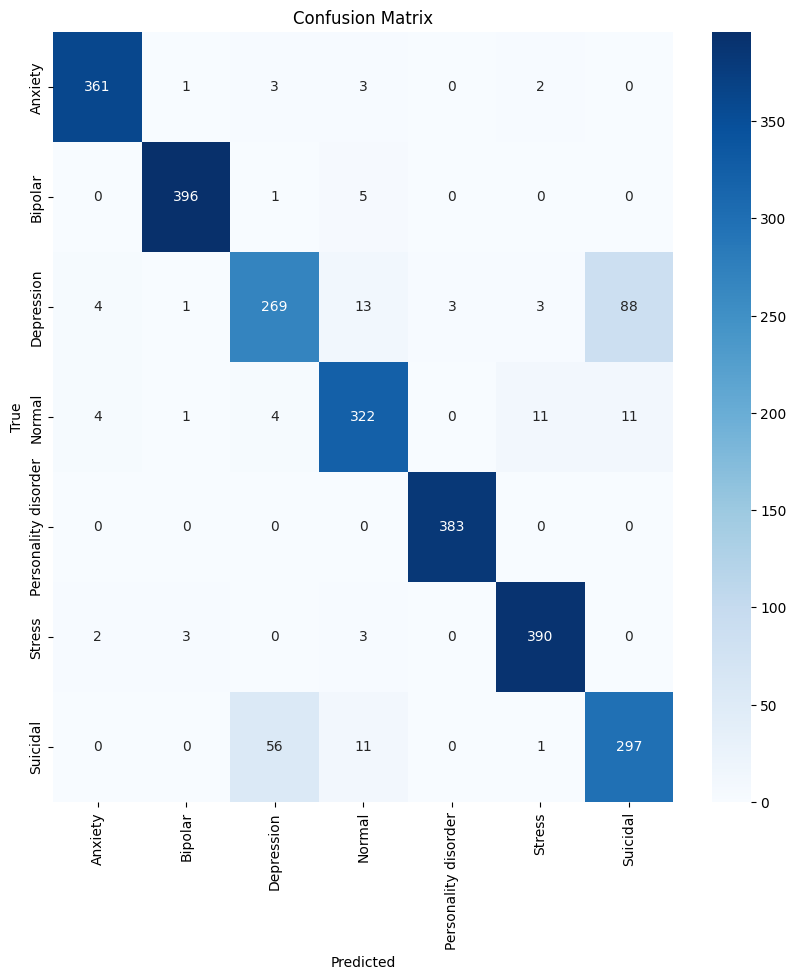

In [ ]:
from sklearn.metrics import confusion_matrix

prediction_output = trainer.predict(test_dataset)
predictions_logits = prediction_output.predictions
true_labels = prediction_output.label_ids

predicted_labels = np.argmax(predictions_logits, axis = 1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save and Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer.save_model('/content/drive/MyDrive/saved_mental_status_bert')
tokenizer.save_pretrained('/content/drive/MyDrive/saved_mental_status_bert')

('/content/drive/MyDrive/saved_mental_status_bert/tokenizer_config.json',
 '/content/drive/MyDrive/saved_mental_status_bert/special_tokens_map.json',
 '/content/drive/MyDrive/saved_mental_status_bert/vocab.txt',
 '/content/drive/MyDrive/saved_mental_status_bert/added_tokens.json')

In [ ]:
import pickle

pickle.dump(label_encoder, open('/content/drive/MyDrive/label_encoder.pkl', 'wb'))

from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

model  = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/saved_mental_status_bert')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/saved_mental_status_bert')

label_encoder = pickle.load(open('/content/drive/MyDrive/label_encoder.pkl', 'rb'))

# Detection System

In [ ]:
import torch

def detection(text):
  text = clean_statement(text)
  inputs = tokenizer(text, return_tensors = 'pt', padding = True, truncation = True, max_length = 200)
  # Remove token_type_ids if present, as DistilBERT models do not use them
  if 'token_type_ids' in inputs:
      del inputs['token_type_ids']
  outputs = model(**inputs)
  logits = outputs.logits
  prediction_label = torch.argmax(logits, dim = 1).item()
  predicted_label = label_encoder.inverse_transform([prediction_label])

  return predicted_label

In [ ]:
text = "I feel so lonely"
detection(text)

array(['Depression'], dtype=object)

In [ ]:
text = "I am happy that i have many friends"
detection(text)

array(['Normal'], dtype=object)

In [ ]:
text = "I don't want to live anymore because every hates me"
detection(text)

array(['Suicidal'], dtype=object)

In [ ]:
text = "ကျွန်တော် တစ်ယောက်တည်းလို့ ခံစားနေတယ်။"
detection(text)

array(['Normal'], dtype=object)

In [ ]:
text = "ကျွန်တော် သူငယ်ချင်းအများကြီးရှိလို့ ဝမ်းသာနေတယ်။"
detection(text)

array(['Normal'], dtype=object)

In [ ]:
text = "လူတိုင်းက ကျွန်တော်ကို မုန်းကြလို့ နောင်တလျှင် မနေချင်တော့ဘူး။"
detection(text)

array(['Normal'], dtype=object)